In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy.stats import entropy

# progress bar
from tqdm import tqdm

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [6]:
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

### Varying bin sizes

In [7]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -13, -13
e_int = -10
n_p, n_r, n_a = 4600, 50, 50

df = tregs.simulate.sim(promoter, tregs.simulate.repact_pbound, [rnap_site, rep_site, crp_site],
                        *[n_NS, n_p, n_r, n_a, rnap_emat, rep_emat, crp_emat, ep_wt, er_wt, ea_wt, e_int],
                        num_mutants=5000,
                        scaling_factor=10*6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP'), (2, 17, 'R', 'LacI')]

In [8]:
def get_signal(footprint, region_param):
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

In [9]:
l_nbins = np.arange(2, 11, 1)

l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for i in tqdm(range(len(l_nbins))):
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(10):
        nbins = l_nbins[i]

        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=5000)
        
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.quantile(mu_data, 1 - 1 / nbins)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append(np.mean(rnap10))
    l_stn_ratio_rnap35.append(np.mean(rnap35))
    l_stn_ratio_lacI.append(np.mean(lacI))

100%|██████████| 9/9 [03:14<00:00, 21.58s/it]


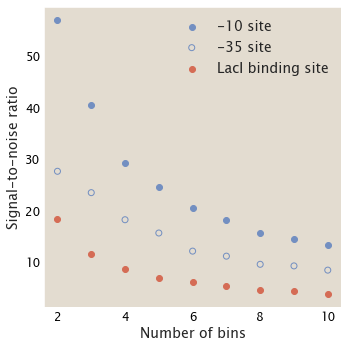

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(l_nbins, l_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(l_nbins, l_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(l_nbins, l_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('Number of bins', fontsize=14)
ax.set_ylabel('Signal-to-noise ratio',fontsize=14)
ax.legend(loc='upper right', frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig('../../manuscript/figures/plots/figS1/bin-size.pdf')

In [11]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=5000)

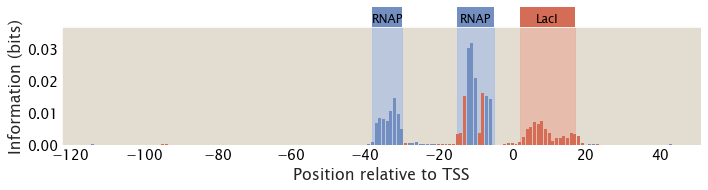

In [13]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2, annotate_stn=False,
                               outfile='../../manuscript/figures/plots/figS1/footprint-cg-2bins.pdf')

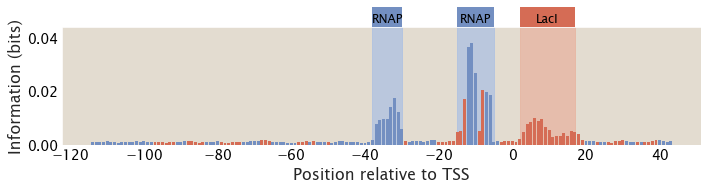

In [12]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=10, annotate_stn=False,
                               outfile='../../manuscript/figures/plots/figS1/footprint-cg-10bins.pdf')

### Trying to figure out why noise increases as the number of bins increases

In [44]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                            *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                            num_mutants=5000)

In [45]:
df.sort_values(by='norm_ct_1', inplace = True)

nbins = 10
splits = np.array_split(df, nbins)
for i in range(len(splits)):
    splits[i]['group'] = i + 1
df = pd.concat(splits)

df

,seq,pbound,ct_0,ct_1,norm_ct_1,group
5000,ttAGcTTTCCCGtCTGGAAAGCGtGttGTGAGCGCAACGCAATTAA...,0.005359,0.722338,0.0,0.000000,1
3221,ACAGtTTTCCCGACTaGAAAGCGGcCAGTGAGCGCAACGCAATTAA...,0.003631,1.548432,0.0,0.000000,1
3227,ACAGtTTTCCCGACcGtAAAGCGGGCAGTaAcCGCAACGCAATTAA...,0.000243,3.873390,0.0,0.000000,1
1449,ACAGGTTTCCCtACTGGAAAGCGtGgAGcGAGCGaAACGCAATTAA...,0.002240,0.296262,0.0,0.000000,1
1448,ACAGGTTTCCCtACTGGAAAGCGGcaAcTGAGCGCAACGCAATTAA...,0.003613,0.106689,0.0,0.000000,1
...,...,...,...,...,...,...
4076,AaAGGTTTCCCGAaTGGAAAGCGtGCAGTGAGCGgAACGCAATTAA...,0.045953,7.224235,33.0,4.567958,10
167,ACAGGTTTCCCGACTGGAAAGCGGGCAGTaAGCGCAgCGCgATTAA...,0.049659,8.258851,41.0,4.964371,10
1824,ACAGGTTTCtCGACTGGAAAGCGGGCAGTGAGCGgAACGCAAgTAA...,0.052069,3.187903,16.0,5.018973,10
2320,ACAGGTTcgCCGACcGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.070911,7.684257,54.0,7.027355,10


In [46]:
mut_groups = np.zeros((10, 160))
for i in range(160):
    for group_i in range(1, 11):
        cnt = 0
        for seq in df[df.group == group_i]['seq']:
            if seq[i] != promoter[i]:
                cnt += 1
        mut_groups[group_i - 1, i] = cnt

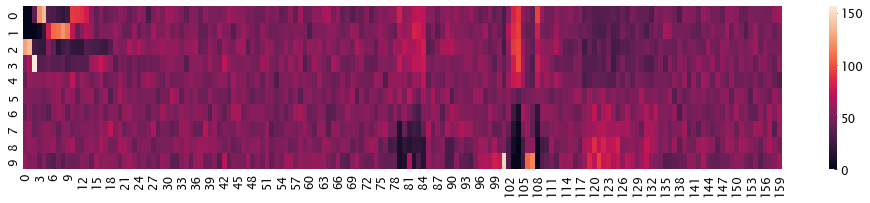

In [50]:
fig, ax = plt.subplots(figsize=(17, 3))
ax = sns.heatmap(mut_groups)

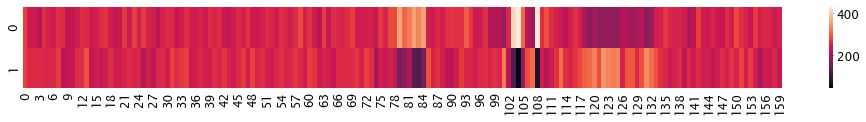

In [55]:
df.sort_values(by='norm_ct_1', inplace = True)

nbins = 2
splits = np.array_split(df, nbins)
for i in range(len(splits)):
    splits[i]['group'] = i + 1
df = pd.concat(splits)

mut_groups = np.zeros((2, 160))
for i in range(160):
    for group_i in range(1, 3):
        cnt = 0
        for seq in df[df.group == group_i]['seq']:
            if seq[i] != promoter[i]:
                cnt += 1
        mut_groups[group_i - 1, i] = cnt

fig, ax = plt.subplots(figsize=(17, 1.5))
ax = sns.heatmap(mut_groups)

In [72]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                            *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                            num_mutants=5000)

In [66]:
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 10
upper_bound = np.quantile(mu_data, 1 - 1 / nbins)

bins = np.linspace(0, upper_bound, nbins).tolist()
bins.append(int(max(mu_data) + 1))

binned = pd.cut(mu_data, bins=bins,
                labels=np.arange(nbins),
                include_lowest=True, right=False)
    
mu_bins = binned.values
df['group'] = mu_bins
df

,seq,pbound,ct_0,ct_1,norm_ct_1,group
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.001268,2.745390,0.0,0.000000,0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000432,1.869449,0.0,0.000000,0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000612,8.368413,0.0,0.000000,0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000121,5.485992,0.0,0.000000,0
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000810,11.295654,1.0,0.088530,0
...,...,...,...,...,...,...
4996,tgAGtTTTtCCGACTGGgAAGCGtGCAGTGAGCGCAACGCAcTTAA...,0.005284,3.176293,1.0,0.314832,3
4997,ttAGGTTTCCCGACTGGAAAGCGGGCtGTGAGCGCAACGaAATTAt...,0.004854,0.429530,0.0,0.000000,0
4998,ttAGGTTTCCtGACTGGgAAGCGGGCAGTGAGCGCAtCGCAATTAt...,0.015171,3.686840,5.0,1.356175,9
4999,ttAGaTTTCCCGAaTGGAAAGCtGGCcGTGAGCGCAACGCAATTgA...,0.000919,6.360801,0.0,0.000000,0


In [67]:
mut_groups = np.zeros((10, 160))
for i in range(160):
    for group_i in range(0, 10):
        cnt = 0
        for seq in df[df.group == group_i]['seq']:
            if seq[i] != promoter[i]:
                cnt += 1
        mut_groups[group_i, i] = cnt

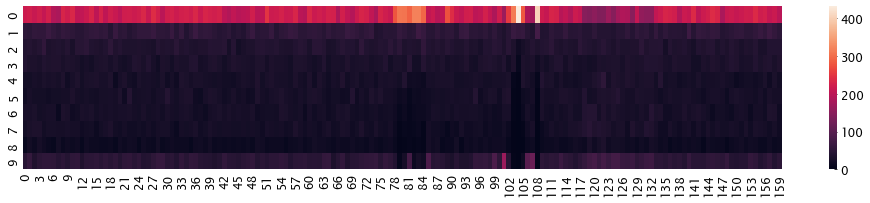

In [68]:
fig, ax = plt.subplots(figsize=(17, 3))
ax = sns.heatmap(mut_groups)

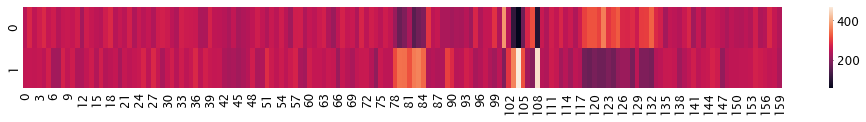

In [71]:
df.sort_values(by='norm_ct_1', inplace = True)

mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.quantile(mu_data, 1 - 1 / nbins)

bins = np.linspace(0, upper_bound, nbins).tolist()
bins.append(int(max(mu_data) + 1))

binned = pd.cut(mu_data, bins=bins,
                labels=np.arange(nbins),
                include_lowest=True, right=False)
    
mu_bins = binned.values
df['group'] = mu_bins

mut_groups = np.zeros((2, 160))
for i in range(160):
    for group_i in range(0, 2):
        cnt = 0
        for seq in df[df.group == group_i]['seq']:
            if seq[i] != promoter[i]:
                cnt += 1
        mut_groups[group_i - 1, i] = cnt

fig, ax = plt.subplots(figsize=(17, 1.5))
ax = sns.heatmap(mut_groups)

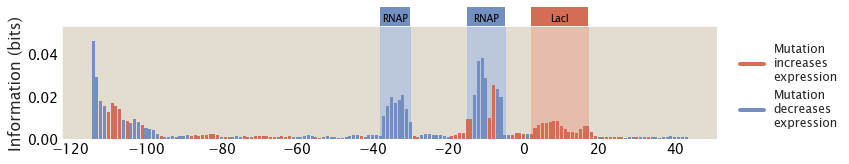

In [49]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                            *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                            num_mutants=5000)

tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=10, annotate_stn=False,
                               outfile='../../manuscript/figures/plots/figS1/footprint-cg-10bins.png')

In [33]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                            *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                            num_mutants=5000)

n_seqs = len(mut_list)
all_mutarr = tregs.footprint.match_seqs(promoter, mut_list)
list_p_b = tregs.footprint.get_p_b(all_mutarr, n_seqs, pseudocount=10**(-6))

H_mu = []
H_mu_b = []
for nbins in range(2, 11, 1):
    mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
    p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)
    list_joint_p = tregs.footprint.get_joint_p(all_mutarr, mu_bins, nbins,
                                            pseudocount=10**(-6), len_promoter=160)
    H_mu.append(entropy(p_mu, base=2))

    H = []
    for i in range(160):
        x = list_joint_p[i]
        y = list_p_b[i]
        S = 0
        for j in range(2):
            for k in range(nbins):
                S -= x[j,k] * np.log2(x[j,k] / y[j])
        H.append(S)
    H_mu_b.append(np.mean(H))

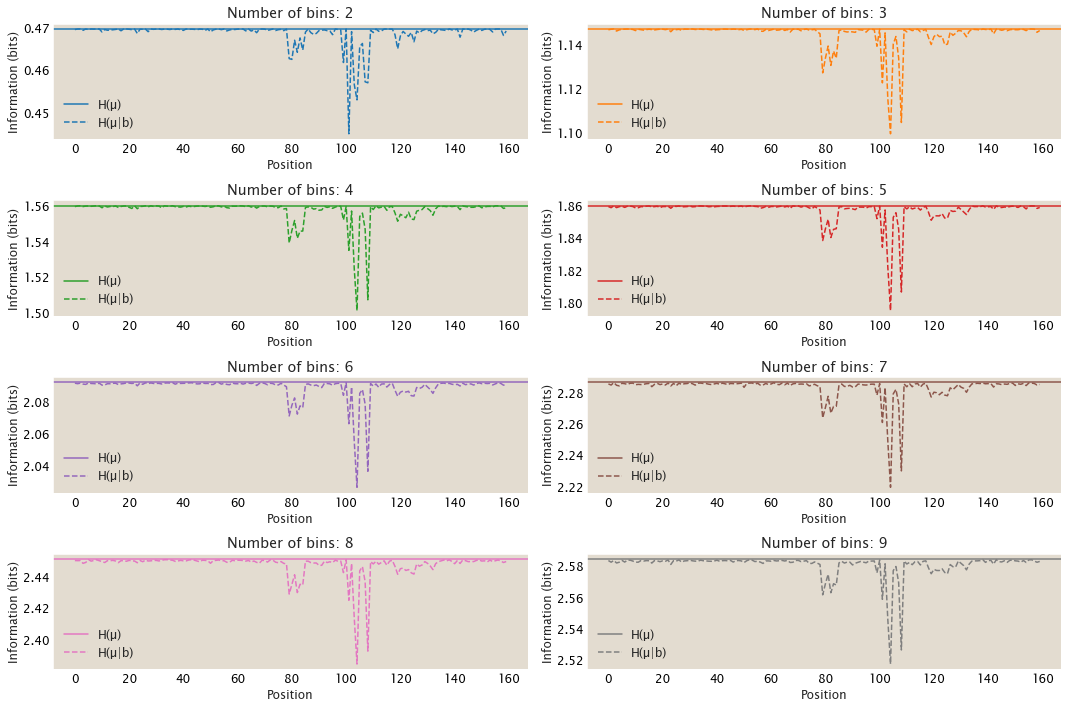

In [29]:
#fig, axes = plt.subplots(4, 2, figsize=(15, 10))
#for i in range(8):
#    ax = axes.flat[i]
#    color = colors[i]
#    ax.axhline(H_mu[i], label='H(µ)', color=color)
#    ax.plot(np.arange(160), H_mu_b[i], label='H(µ|b)', color=color, linestyle='--')
#    ax.set_xlabel('Position')
#    ax.set_ylabel('Information (bits)')
#    ax.set_title('Number of bins: ' + str(i + 2))
#    ax.legend(frameon=False)
#plt.tight_layout()

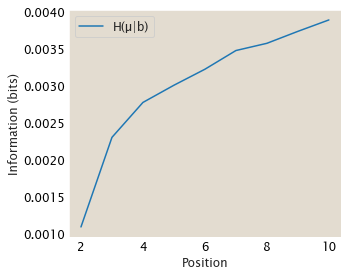

In [39]:
fig, ax = plt.subplots(figsize=(5,4))
#ax.plot(np.arange(2, 11, 1), H_mu, label='H(µ)')
ax.plot(np.arange(2, 11, 1), np.array(H_mu) - np.array(H_mu_b), label='H(µ|b)')
ax.set_xlabel('Position')
ax.set_ylabel('Information (bits)')
ax.legend()
plt.tight_layout()

### Using ACGT instead of wild-type vs. mutant

In [14]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -13, -13
e_int = -10
n_p, n_r, n_a = 4600, 50, 50

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP'), (2, 17, 'R', 'LacI')]

In [15]:
stn_ratio_cg = []
stn_ratio_wcg = []
for i in range(20):
    df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=5000)

    footprint_cg = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
    total_signal = 0
    for region in region_params:
        total_signal += np.sum(footprint_cg[(region[0]+115):(region[1]+116)])
    stn_ratio = total_signal / (np.sum(footprint_cg) - total_signal)
    stn_ratio_cg.append(stn_ratio)
                        
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']

    n_seqs = len(mut_list)
    len_promoter = 160
    nbins = 2
    upper_bound = np.mean(mu_data)
    pseudocount = 10**(-6)

    mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
    p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)

    letters = ['A', 'T', 'C', 'G']

    list_p_b = []
    for position in range(len_promoter):
        dict_cnt = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
        for mut in mut_list:
            mut = mut.upper()
            letter = mut[position]
            dict_cnt[letter] += 1
        list_cnt = []
        for letter in letters:
            list_cnt.append(dict_cnt[letter])
        p_b = np.asarray(list_cnt) / n_seqs
        list_p_b.append(p_b)

    list_joint_p = []
    for position in range(len_promoter):
        joint_p = np.zeros((4, nbins)) + pseudocount
        # adding a pseudocount to prevent zero-division error
        for i, mut in enumerate(mut_list):
            mut = mut.upper()
            for j in range(nbins):
                for i_letter in range(4):
                    if (mut[position] == letters[i_letter]) & (mu_bins[i] == j):
                        joint_p[i_letter][j] += 1

        joint_p /= np.sum(joint_p)
        list_joint_p.append(joint_p)

    footprint_wcg = []
    for position in range(len_promoter):
        p_b = list_p_b[position]
        joint_p = list_joint_p[position]

        mi = 0
        for i in range(len(p_mu)):
            for i_letter in range(4):
                mi += joint_p[i_letter][i] * np.log2(joint_p[i_letter][i] / (p_b[i_letter] * p_mu[i]))
        footprint_wcg.append(mi)

    total_signal = 0
    for region in region_params:
        total_signal += np.sum(footprint_wcg[(region[0]+115):(region[1]+116)])
    stn_ratio = total_signal / (np.sum(footprint_wcg) - total_signal)
    stn_ratio_wcg.append(stn_ratio)

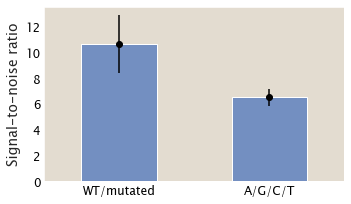

In [36]:
fig, ax = plt.subplots(figsize=(5.2,3))

x = ['WT/mutated', 'A/G/C/T']
y = [np.mean(stn_ratio_cg), np.mean(stn_ratio_wcg)]

ax.bar(x, y, width=0.5, color='#738FC1', edgecolor=None, align='center')
ax.errorbar(x, y, yerr=[np.std(stn_ratio_cg), np.std(stn_ratio_wcg)], fmt="o", color='black')
#ax.set_xticks(x, label=x_ticks)
ax.set_ylabel('Signal-to-noise ratio', fontsize=14)
ax.set_xlim(-0.5, 1.5)
 
plt.tight_layout()
plt.savefig('../../manuscript/figures/plots/figS1/stn_atcg.pdf', dpi=300)
plt.show()

In [17]:
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

n_seqs = len(mut_list)
len_promoter = 160
nbins = 2
upper_bound = np.mean(mu_data)
pseudocount = 10**(-6)

mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)

letters = ['A', 'T', 'C', 'G']

list_p_b = []
for position in range(len_promoter):
    dict_cnt = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
    for mut in mut_list:
        mut = mut.upper()
        letter = mut[position]
        dict_cnt[letter] += 1
    list_cnt = []
    for letter in letters:
        list_cnt.append(dict_cnt[letter])
    p_b = np.asarray(list_cnt) / n_seqs
    list_p_b.append(p_b)

list_joint_p = []
for position in range(len_promoter):
    joint_p = np.zeros((4, nbins)) + pseudocount
    # adding a pseudocount to prevent zero-division error
    for i, mut in enumerate(mut_list):
        mut = mut.upper()
        for j in range(nbins):
            for i_letter in range(4):
                if (mut[position] == letters[i_letter]) & (mu_bins[i] == j):
                    joint_p[i_letter][j] += 1

    joint_p /= np.sum(joint_p)
    list_joint_p.append(joint_p)

footprint_wcg = []
for position in range(len_promoter):
    p_b = list_p_b[position]
    joint_p = list_joint_p[position]

    mi = 0
    for i in range(len(p_mu)):
        for i_letter in range(4):
            mi += joint_p[i_letter][i] * np.log2(joint_p[i_letter][i] / (p_b[i_letter] * p_mu[i]))
    footprint_wcg.append(mi)

In [22]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]

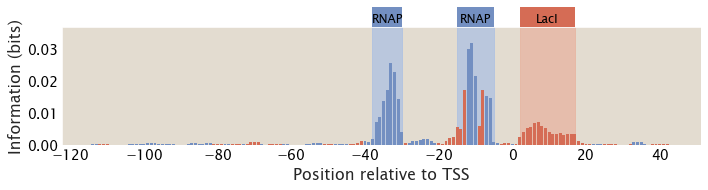

In [26]:
fig, ax = plt.subplots(figsize=(10,2.9))
ax.set_ylabel('Information (bits)', fontsize=16)
ax.set_xlabel('Position relative to TSS', fontsize=16)

footprint = footprint_wcg

windowsize = 3
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)

ax.set_ylim(top=max(footprint_smoothed)*1.15)
max_signal = max(footprint_smoothed)
total_signal = 0
for region in region_params:
    tregs.footprint.label_binding_site(ax, region[0], region[1], max_signal, region[2], region[3])
    total_signal += np.sum(footprint[(region[0]+115):(region[1]+116)])
stn_ratio = total_signal / (np.sum(footprint) - total_signal)

ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors, linewidth=0)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig('../../manuscript/figures/plots/figS1/footprint-wcg.pdf')
plt.show()